In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

torch.cuda.is_available()

True

In [3]:
batch_size_train = 64
batch_size_test = 1000

log_interval = 10

In [20]:
def MNIST():
  MNIST_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))
  MNIST_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))

  train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size=batch_size_train, shuffle=True)
  test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size=batch_size_test, shuffle=True)
  return train_loader, test_loader

def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    perm_inds = list(range(28*28))
    np.random.shuffle(perm_inds)
    for i in range(len(mnist.data)):
        mnist.data[i] = mnist.data[i].flatten()[perm_inds].reshape(28,28)
    print("done.")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

class NetNoise(nn.Module):
    def __init__(self):
        super(NetNoise, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(3380, 50)
        self.fc2 = nn.Linear(50, 105)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        print(x.shape)
        # x = x.view(-1, 3380)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

def train(model, optimizer, train_loader, epoch=1):
  train_losses = []
  model.train()
  for e in range(epoch):
      for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()
          output = model(data)
        #   print(output, len(output), type(output))
        #   print(target, len(target), type(target))
        #   break
          loss = F.cross_entropy(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % log_interval == 0:
              print(f"Epoch {e+1} [{batch_idx * len(data)} / {len(train_loader.dataset)}]       loss: {loss.item()}")
          train_losses.append(loss.item())
  return train_losses

def trainNoise(model, optimizer, train_loader, epoch=1):
  train_losses = []
  model.train()
  for e in range(epoch):
      for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()
          output = model(data)#.argmax(dim=1)
          print(output, len(output), type(output))
          print(target, len(target), type(target))
          print(data.shape)
          loss = F.cross_entropy(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % log_interval == 0:
              print(f"Epoch {e+1} [{batch_idx * len(data)} / {len(train_loader.dataset)}]       loss: {loss.item()}")
          train_losses.append(loss.item())
  return train_losses

def test(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          output = model(data)
          test_loss += F.cross_entropy(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [5]:
class L2Norm(nn.Module):
    def forward(self, x):
        return x / x.norm(p=2, dim=1, keepdim=True)


class SmallAlexNet(nn.Module):
    def __init__(self, in_channel=3, feat_dim=128):
        super(SmallAlexNet, self).__init__()

        blocks = []

        # conv_block_1
        blocks.append(nn.Sequential(
            nn.Conv2d(in_channel, 96, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        ))

        # conv_block_2
        blocks.append(nn.Sequential(
            nn.Conv2d(96, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        ))

        # conv_block_3
        blocks.append(nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
        ))

        # conv_block_4
        blocks.append(nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
        ))

        # conv_block_5
        blocks.append(nn.Sequential(
            nn.Conv2d(384, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        ))

        # fc6
        blocks.append(nn.Sequential(
            nn.Flatten(),
            nn.Linear(192 * 7 * 7, 4096, bias=False),  # 256 * 6 * 6 if 224 * 224
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        ))

        # fc7
        blocks.append(nn.Sequential(
            nn.Linear(4096, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        ))

        # fc8
        blocks.append(nn.Sequential(
            nn.Linear(4096, feat_dim),
            L2Norm(),
        ))

        self.blocks = nn.ModuleList(blocks)
        self.init_weights_()

    def init_weights_(self):
        def init(m):
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(m.weight, 0, 0.02)
                if getattr(m, 'bias', None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                if getattr(m, 'weight', None) is not None:
                    nn.init.ones_(m.weight)
                if getattr(m, 'bias', None) is not None:
                    nn.init.zeros_(m.bias)

        self.apply(init)

    def forward(self, x, *, layer_index=-1, average=True):
        if layer_index < 0:
            layer_index += len(self.blocks)
        for layer in self.blocks[:(layer_index + 1)]:
            x = layer(x)

        # NEW: spatial averaging
        if average:
            if x.ndim == 4:
                x = x.mean(dim=-1)
            if x.ndim == 3:
                x = x.mean(dim=-1)

        return x

# Normal learning

Epoch 1 [0 / 60000]       loss: 2.353341817855835
Epoch 1 [640 / 60000]       loss: 2.2534170150756836
Epoch 1 [1280 / 60000]       loss: 2.038182497024536
Epoch 1 [1920 / 60000]       loss: 1.6753305196762085
Epoch 1 [2560 / 60000]       loss: 1.4215847253799438
Epoch 1 [3200 / 60000]       loss: 1.1205413341522217
Epoch 1 [3840 / 60000]       loss: 0.94857257604599
Epoch 1 [4480 / 60000]       loss: 0.934394359588623
Epoch 1 [5120 / 60000]       loss: 0.8098490834236145
Epoch 1 [5760 / 60000]       loss: 0.9189363718032837
Epoch 1 [6400 / 60000]       loss: 1.1348211765289307
Epoch 1 [7040 / 60000]       loss: 0.5775309801101685
Epoch 1 [7680 / 60000]       loss: 0.46694377064704895
Epoch 1 [8320 / 60000]       loss: 0.9160143733024597
Epoch 1 [8960 / 60000]       loss: 0.5585536360740662
Epoch 1 [9600 / 60000]       loss: 0.7802786827087402
Epoch 1 [10240 / 60000]       loss: 0.6829176545143127
Epoch 1 [10880 / 60000]       loss: 0.8122544288635254
Epoch 1 [11520 / 60000]       loss

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0896, Accuracy: 9708/10000 (97%)



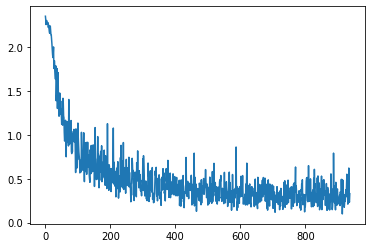

In [6]:
train_loader, test_loader = MNIST()

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = train(model, optimizer, train_loader)
plt.plot(train_losses)
test(model, test_loader)

# Learning Permuted Mnist

starting permutation...
done.
Epoch 1 [0 / 60000]       loss: 2.316282033920288
Epoch 1 [640 / 60000]       loss: 2.286494255065918
Epoch 1 [1280 / 60000]       loss: 2.2644829750061035
Epoch 1 [1920 / 60000]       loss: 2.36024808883667
Epoch 1 [2560 / 60000]       loss: 2.264338731765747
Epoch 1 [3200 / 60000]       loss: 2.281928300857544
Epoch 1 [3840 / 60000]       loss: 2.1592259407043457
Epoch 1 [4480 / 60000]       loss: 2.0603256225585938
Epoch 1 [5120 / 60000]       loss: 2.1651523113250732
Epoch 1 [5760 / 60000]       loss: 1.9653340578079224
Epoch 1 [6400 / 60000]       loss: 1.7395049333572388
Epoch 1 [7040 / 60000]       loss: 1.8491705656051636
Epoch 1 [7680 / 60000]       loss: 1.5837652683258057
Epoch 1 [8320 / 60000]       loss: 1.5509052276611328
Epoch 1 [8960 / 60000]       loss: 1.4796068668365479
Epoch 1 [9600 / 60000]       loss: 1.5684483051300049
Epoch 1 [10240 / 60000]       loss: 1.2443853616714478
Epoch 1 [10880 / 60000]       loss: 1.3107300996780396
Epoch 

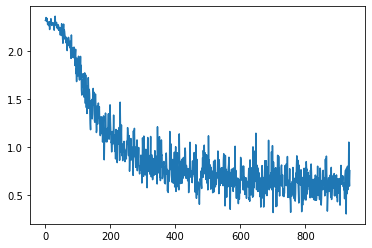

In [7]:
train_loader, test_loader = MNIST()

permute_mnist(train_loader.dataset, 2137)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = train(model, optimizer, train_loader)
plt.plot(train_losses)
test(model, test_loader)

# Pretraining on noise data

In [8]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def dead_leaves_squares():
    imagefolder = "data/dead_leaves-squares/"
    batch_size = 128
    resize_image = True

    class TwoCropsTransform:
        """Take two random crops of one image as the query and key."""

        def __init__(self, base_transform):
            self.base_transform = base_transform

        def __call__(self, x):
            q = self.base_transform(x)
            k = self.base_transform(x)
            return [q, k]

    transform_array = []
    if resize_image:
        transform_array.append(
            torchvision.transforms.Resize((96,96))
        )

    transform_array += [
        torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        torchvision.transforms.RandomGrayscale(p=0.2),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.44087801806139126, 0.42790631331699347, 0.3867879370752931),
            (0.26826768628079806, 0.2610450402318512, 0.26866836876860795),
        ),
    ]

    transform = torchvision.transforms.Compose(transform_array)
    # transform = TwoCropsTransform(transform)


    train_path = os.path.join(imagefolder, 'train')
    print(f'Loading data from {imagefolder} as imagefolder')
    dataset = torchvision.datasets.ImageFolder(
        train_path,
        transform=transform)

    val_split = 0.3
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    train_dataset = Subset(dataset, train_idx).dataset
    test_dataset = Subset(dataset, test_idx).dataset

    # loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    return train_loader, test_loader

In [12]:
train_loader, test_loader = dead_leaves_squares()

model = NetNoise()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_losses = []
model.train()
for e in range(1):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        print(output, len(output), output.shape)
        print(target, len(target))
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Epoch {e+1} [{batch_idx * len(data)} / {len(train_loader.dataset)}]       loss: {loss.item()}")
        train_losses.append(loss.item())

Loading data from data/dead_leaves-squares/ as imagefolder
tensor([[ 0.0128,  0.0652, -0.0131,  ..., -0.0469,  0.0647,  0.1038],
        [ 0.0104,  0.0493, -0.0246,  ..., -0.0040,  0.0476,  0.0603],
        [ 0.0658, -0.0503, -0.0364,  ...,  0.0515,  0.0461,  0.0413],
        ...,
        [ 0.0553,  0.1975,  0.0296,  ...,  0.2698, -0.1577,  0.0980],
        [-0.1684, -0.3168, -0.1357,  ...,  0.1510,  0.1621, -0.5887],
        [ 0.0642,  0.0242, -0.0944,  ..., -0.0302,  0.0254,  0.1770]],
       grad_fn=<AddmmBackward0>) 1352 torch.Size([1352, 104])
tensor([ 80,  62,  56,  21,  61,  48,  32,  16,  35,  98,  52,   1,  88,  36,
         84,  87,  85,   0,  32,  22,  43,  33,  22,  58,   8,  48,  55,  71,
         58,  44,  82,   2,  77,  72,  82,  63,  66,  65,  31,   3,  86,  56,
         38,  44,  71, 103,  79,  71,  13,  10,  21,  93,  64,  34, 100,  63,
          2,  43,  98,  65,  13,  10,  42,  60, 100,  76,  35,  64,   7,  64,
          2,  90,  13,  94,  35,  81,  29,  69,   5, 10

ValueError: Expected input batch_size (1352) to match target batch_size (128).

In [ ]:
1352/104

13.0

In [21]:
train_loader, test_loader = dead_leaves_squares()

model = NetNoise()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = trainNoise(model, optimizer, train_loader)
# plt.plot(train_loader)
# test(model, test_loader)

Loading data from data/dead_leaves-squares/ as imagefolder
torch.Size([128, 20, 13, 13])
tensor([[-0.0741, -0.0823,  0.1031,  ...,  0.1187, -0.0806,  0.1113],
        [-0.2770, -0.0150, -0.1224,  ...,  0.1290, -0.1293,  0.1391],
        [-0.0032, -0.0371,  0.0153,  ...,  0.0141,  0.0617,  0.0630],
        ...,
        [ 0.0467, -0.0141,  0.0864,  ..., -0.0048,  0.0624,  0.1242],
        [ 0.0380,  0.0101,  0.0381,  ..., -0.1135, -0.0492,  0.2268],
        [-0.0717, -0.1147, -0.0970,  ...,  0.0086,  0.0511, -0.0087]],
       grad_fn=<AddmmBackward0>) 128 <class 'torch.Tensor'>
tensor([ 95,  88,  82,  42,  12,  55,  79,  86,   9,  18,  17,  53,  58,  88,
         80,  98,  64,  75, 102,  84,  92,  21,  91,  56,   9,  81,  38,  66,
         59,  77,  98,  86,  50,  13,  72,  97,  91,  28,  49,  53,  98,  68,
         78,  70,  68, 101,  36,  63,   2,  27,   9,  83,   9,  50,  72,  60,
         62,  92,  39,  35,  17,   4,  78,  88,  77,  86,  37,  25,  72,  29,
         42,  89,  28,  94,

KeyboardInterrupt: 

In [18]:
train_loader, test_loader = dead_leaves_squares()

model = SmallAlexNet()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = trainNoise(model, optimizer, train_loader)

Loading data from data/dead_leaves-squares/ as imagefolder


KeyboardInterrupt: 

# freeze and train on MNIST

In [ ]:
model.conv1.requires_grad_(False)
model.conv2.requires_grad_(False)
model.conv2_drop.requires_grad_(False)
model.fc1.requires_grad_(False)
model.fc2.requires_grad_(False)

Linear(in_features=50, out_features=10, bias=True)